Here, we examine parametric sensitivity of the structure model on a small simulated dataset

In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils, cavi_lib
from vb_lib.preconditioner_lib import get_mfvb_cov
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/home/rliu/anaconda3/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp
onp.random.seed(53453)

# Draw data

In [3]:
n_obs = 50
n_loci = 100
n_pop = 4

In [4]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

Text(0.5, 0, 'individual')

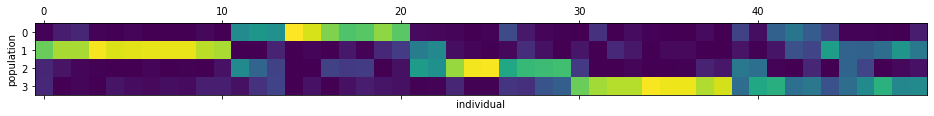

In [5]:
plt.matshow(true_ind_admix_propn.T)
plt.ylabel('population')
plt.xlabel('individual')

In [6]:
g_obs.shape

(50, 100, 3)

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [8]:
k_approx = 8

In [9]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [10]:
use_logitnormal_sticks = True

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (100, 8, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_propn_mean] = NumericArrayPattern (50, 7) (lb=-inf, ub=inf)
	[ind_mix_stick_propn_info] = NumericArrayPattern (50, 7) (lb=0.0001, ub=inf)


## Initialize 

In [11]:
vb_params_dict = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                                seed = 34221)

In [12]:
vb_params_dict.keys()

odict_keys(['pop_freq_beta_params', 'ind_mix_stick_propn_mean', 'ind_mix_stick_propn_info'])

In [13]:
def get_vb_expectations(vb_params_dict, use_logitnormal_sticks): 
    if use_logitnormal_sticks: 
        e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                            vb_params_dict['ind_mix_stick_propn_mean'], 
                            vb_params_dict['ind_mix_stick_propn_info'],
                            gh_loc, gh_weights)

    else: 
        ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
        e_stick_lengths = \
                modeling_lib.get_e_beta(ind_mix_stick_beta_params)
        e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)

    e_pop_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])
    
    return e_ind_admix, e_pop_freq

Text(0.5, 0, 'individual')

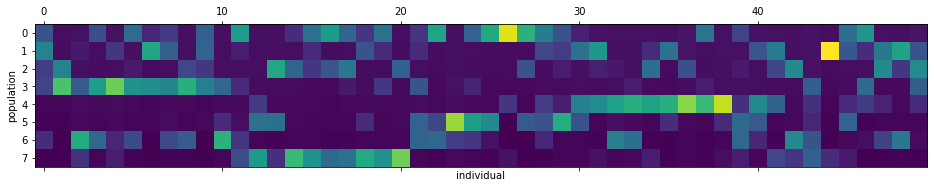

In [14]:
plt.matshow(get_vb_expectations(vb_params_dict, use_logitnormal_sticks)[0].transpose())
plt.ylabel('population')
plt.xlabel('individual')

# Run CAVI

In [15]:
# get beta parameters for sticks and populations
vb_opt_dict, vb_opt, ez_opt, kl_path, time_vec = \
    cavi_lib.run_cavi(g_obs, vb_params_dict, 
                        vb_params_paragami, 
                        prior_params_dict,
                        gh_loc = gh_loc, gh_weights = gh_weights,
                        max_iter = 1000,
                        x_tol = 1e-3, 
                        print_every = 20)


CAVI compile time: 2.95sec

 running CAVI ...
iteration [20]; kl:7569.486015; elapsed: 0.3072secs
iteration [40]; kl:7523.255849; elapsed: 0.1888secs
iteration [60]; kl:7501.677268; elapsed: 0.1683secs
iteration [80]; kl:7498.590973; elapsed: 0.2437secs
iteration [100]; kl:7492.391143; elapsed: 0.1802secs
iteration [120]; kl:7477.893815; elapsed: 0.1668secs
iteration [140]; kl:7477.302714; elapsed: 0.1478secs
iteration [160]; kl:7477.110602; elapsed: 0.1575secs
iteration [180]; kl:7477.037184; elapsed: 0.1508secs
iteration [200]; kl:7477.009621; elapsed: 0.1728secs
iteration [220]; kl:7476.990716; elapsed: 0.1579secs
iteration [240]; kl:7476.977235; elapsed: 0.1749secs
iteration [260]; kl:7476.967303; elapsed: 0.1701secs
iteration [280]; kl:7476.95978; elapsed: 0.1753secs
iteration [300]; kl:7476.953951; elapsed: 0.1578secs
iteration [320]; kl:7476.949354; elapsed: 0.1809secs
iteration [340]; kl:7476.94568; elapsed: 0.1676secs
iteration [360]; kl:7476.942717; elapsed: 0.171secs
iterati

In [16]:
(vb_opt**2).mean()

DeviceArray(3.81495955, dtype=float64)

In [17]:
(ez_opt**2).mean()

DeviceArray(0.07810916, dtype=float64)

# Check out the fit

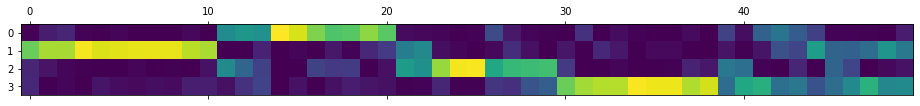

In [18]:
# truth
plt.matshow(true_ind_admix_propn.T)

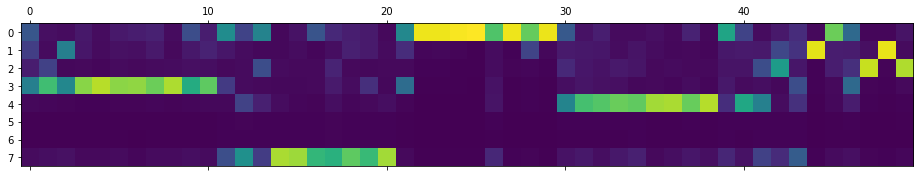

In [19]:
# fitted
e_ind_admix = get_vb_expectations(vb_opt_dict, use_logitnormal_sticks)[0]
plt.matshow(e_ind_admix.T)

# Define sensitivity object

In [20]:
# initial prior alpha
use_free_alpha = True
prior_alpha0 = prior_params_paragami['dp_prior_alpha'].flatten(prior_params_dict['dp_prior_alpha'], 
                                                              free = use_free_alpha)

In [21]:
# set up objective as function of vb params and prior param 

def objective_fun(vb_params_dict, alpha): 
    
    _prior_params_dict = deepcopy(prior_params_dict)
    _prior_params_dict['dp_prior_alpha'] = alpha
    
    return structure_model_lib.get_kl(g_obs, vb_params_dict, _prior_params_dict,
                    gh_loc = gh_loc, gh_weights = gh_weights)


objective_fun_free = paragami.FlattenFunctionInput(
                                original_fun=objective_fun, 
                                patterns = [vb_params_paragami, prior_params_paragami['dp_prior_alpha']],
                                free = [True, use_free_alpha],
                                argnums = [0, 1])


In [22]:
objective_fun_free(vb_opt, prior_alpha0)

DeviceArray(7476.93500793, dtype=float64)

### Set up hessian solver

In [23]:
t0 = time.time()
mfvb_preconditioner = \
    get_mfvb_cov(vb_opt_dict, vb_params_paragami, use_logitnormal_sticks, return_info = True)

print('preconditioner time: {:0.3}sec'.format(time.time() - t0))

preconditioner time: 0.3sec


In [24]:
import vittles

In [25]:
# get hessian-vector product
def get_jac_hvp_fun(f):
    def hvp(x, v):
        return jax.jvp(jax.grad(f), (x, ), (v, ))[1]
    return hvp

In [26]:
obj_fun_hvp = jax.jit(get_jac_hvp_fun(lambda x : objective_fun_free(x, prior_alpha0)))

In [27]:
cg_solver = vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_opt, x), 
                                            dim = len(vb_opt), 
                                            cg_opts = {'M': mfvb_preconditioner})


In [28]:
vb_sens = HyperparameterSensitivityLinearApproximation(objective_fun_free,
                                                        vb_opt,
                                                        prior_alpha0, 
                                                        hess_solver = cg_solver)


Compiling objective function derivatives ... 
Compile time: 0.307sec

Objective function derivative time: 0.000162sec

Linear system compile time: 1.61sec
Linear system time: 1.62sec


# Perturb alpha. Check results

In [51]:
# set new alpha 
new_alpha = np.array([5.])

prior_params_pert_dict = deepcopy(prior_params_dict)
prior_params_pert_dict['dp_prior_alpha'] = new_alpha


In [52]:
print('initial alpha, ', prior_params_dict['dp_prior_alpha'])
print('perturbed alpha, ', prior_params_pert_dict['dp_prior_alpha'])


initial alpha,  [3.]
perturbed alpha,  [5.]


In [53]:
# linear response prediction 
lr_vb_free_params = \
    vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami['dp_prior_alpha'].flatten(prior_params_pert_dict['dp_prior_alpha'], 
                                                        free = use_free_alpha))

print('l_inf diff: ', np.max(np.abs(lr_vb_free_params - vb_opt)))


l_inf diff:  9.237904359152814


In [54]:
(lr_vb_free_params**2).mean()

DeviceArray(4.48941641, dtype=float64)

### reoptimize

In [32]:
new_init_dict = deepcopy(vb_opt_dict)
new_init_free = vb_params_paragami.flatten(new_init_dict, free = True)

In [33]:
vb_pert_dict, vb_opt_pert, e_z_pert = \
    cavi_lib.run_cavi(g_obs, deepcopy(new_init_dict), 
                                            vb_params_paragami,
                                            prior_params_pert_dict,
                                            gh_loc = gh_loc, gh_weights = gh_weights,
                                            max_iter = 1000,
                                            x_tol = 1e-4, 
                                            print_every = 20)[0:3]

CAVI compile time: 1.85sec

 running CAVI ...
iteration [20]; kl:7709.586826; elapsed: 0.1756secs
iteration [40]; kl:7707.715974; elapsed: 0.1915secs
iteration [60]; kl:7707.304743; elapsed: 0.1719secs
iteration [80]; kl:7707.221713; elapsed: 0.2545secs
iteration [100]; kl:7707.203374; elapsed: 0.1876secs
iteration [120]; kl:7707.19896; elapsed: 0.2026secs
iteration [140]; kl:7707.197829; elapsed: 0.172secs
iteration [160]; kl:7707.197546; elapsed: 0.1822secs
iteration [180]; kl:7707.197472; elapsed: 0.1721secs
iteration [200]; kl:7707.197451; elapsed: 0.1891secs
CAVI done.
Elapsed: 203 steps in 1.93 seconds


### compare

In [34]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt): 
    plt.plot(lr_vb_free_params - vb_opt, 
             vb_opt_pert - vb_opt, 
             '+', color = 'red')

    plt.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

    plt.xlabel('lr')
    plt.ylabel('re-optimized')


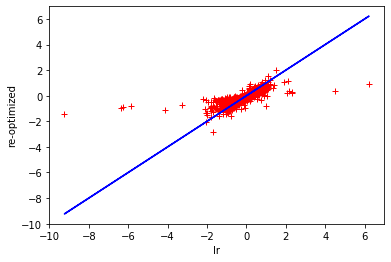

In [35]:
# compare free parameters
print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt)

In [36]:
# compare expectations
init_e_ind_admix, init_e_pop_freq = get_vb_expectations(vb_opt_dict, use_logitnormal_sticks)
pert_e_ind_admix, pert_e_pop_freq = get_vb_expectations(vb_pert_dict, use_logitnormal_sticks)
lr_e_ind_admix, lr_e_pop_freq = get_vb_expectations(vb_params_paragami.fold(lr_vb_free_params, free = True), 
                                                    use_logitnormal_sticks)

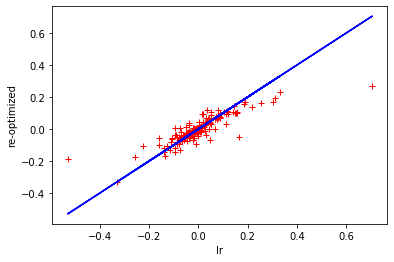

In [37]:
print_diff_plot(lr_e_ind_admix, pert_e_ind_admix, init_e_ind_admix)

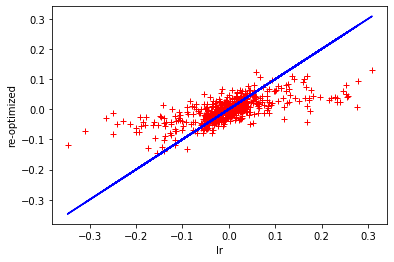

In [38]:
print_diff_plot(lr_e_pop_freq, pert_e_pop_freq, init_e_pop_freq)

In [39]:
print('init number of cluster: ', cluster_quantities_lib.get_e_num_clusters_from_ez(init_e_ind_admix))

print('pert number of cluster: ', cluster_quantities_lib.get_e_num_clusters_from_ez(pert_e_ind_admix))
print('lr number of cluster: ', cluster_quantities_lib.get_e_num_clusters_from_ez(lr_e_ind_admix))

init number of cluster:  6.6575153691676645
pert number of cluster:  6.791736719834658
lr number of cluster:  6.715959560279319


# Fit for a range of alpha

In [40]:
alpha_list = np.arange(1, 8)

In [41]:
def refit_with_alpha(alpha, new_init_dict):
    # sets new alpha, returns new vb optimum
    
    # set new prior
    new_alpha = np.array([alpha])

    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['dp_prior_alpha'] = new_alpha
    
    vb_opt_pert = cavi_lib.run_cavi(g_obs, deepcopy(new_init_dict), 
                                    vb_params_paragami,
                                    prior_params_pert_dict,
                                    gh_loc = gh_loc, gh_weights = gh_weights, 
                                    max_iter = 1000,
                                    x_tol = 1e-3, 
                                    print_every = 20)[1]

        
    return vb_opt_pert


In [42]:
print('alphas: ', alpha_list)

alphas:  [1 2 3 4 5 6 7]


In [43]:
vb_pert_list = []
for alpha in alpha_list: 
    print('\n re-optimzing with alpha = ', alpha)
    
    vb_pert_list.append(refit_with_alpha(alpha, new_init_dict))



 re-optimzing with alpha =  1
CAVI compile time: 2.46sec

 running CAVI ...
iteration [20]; kl:7020.702091; elapsed: 0.1636secs
iteration [40]; kl:7007.286488; elapsed: 0.1889secs
iteration [60]; kl:7001.145095; elapsed: 0.1833secs
iteration [80]; kl:6997.283711; elapsed: 0.2099secs
iteration [100]; kl:6995.522633; elapsed: 0.1863secs
iteration [120]; kl:6994.17346; elapsed: 0.1926secs
iteration [140]; kl:6992.982878; elapsed: 0.1927secs
iteration [160]; kl:6992.76356; elapsed: 0.3238secs
iteration [180]; kl:6992.709417; elapsed: 0.1985secs
iteration [200]; kl:6992.676544; elapsed: 0.3327secs
iteration [220]; kl:6992.642335; elapsed: 0.2221secs
iteration [240]; kl:6992.596735; elapsed: 0.2213secs
iteration [260]; kl:6992.528885; elapsed: 0.2233secs
iteration [280]; kl:6992.418417; elapsed: 0.2255secs
iteration [300]; kl:6992.137848; elapsed: 0.224secs
iteration [320]; kl:6991.285953; elapsed: 0.2102secs
iteration [340]; kl:6988.898545; elapsed: 0.1962secs
iteration [360]; kl:6987.2287

# Check free parameters

In [44]:
lr_list = []

for alpha in alpha_list: 
    
    # set alpha 
    new_alpha = np.array([alpha])
    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['dp_prior_alpha'] = new_alpha
    
    # get linear response
    lr_list.append(vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami['dp_prior_alpha'].flatten(prior_params_pert_dict['dp_prior_alpha'], 
                                                        free = use_free_alpha)))


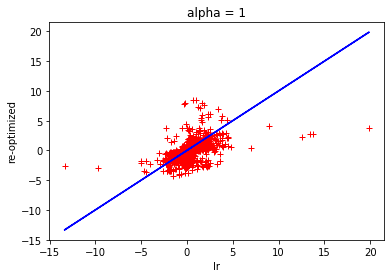

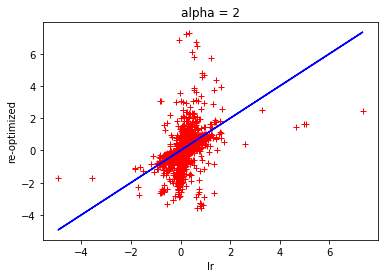

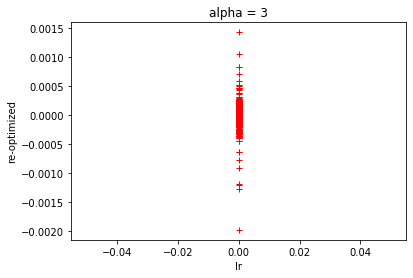

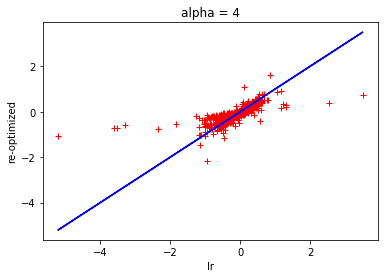

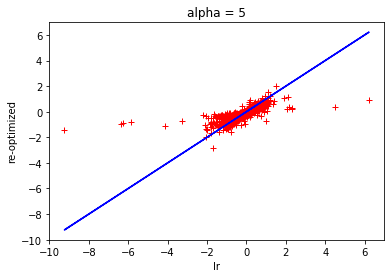

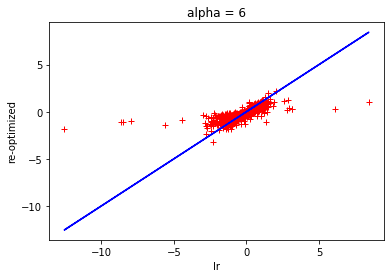

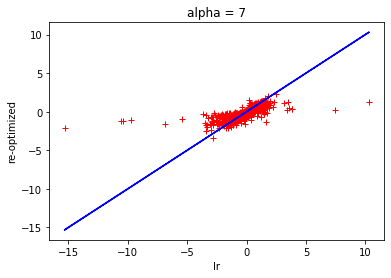

In [45]:
for i in range(len(alpha_list)): 
    plt.figure()
    print_diff_plot(lr_list[i], vb_pert_list[i], vb_opt)
    
    plt.title('alpha = {}'.format(alpha_list[i]))


# Number of clusters

In [47]:
import numpy as onp

In [48]:
lr_e_num_clusters_vec = onp.zeros(len(alpha_list))
refit_e_num_clusters_vec = onp.zeros(len(alpha_list))

for i in range(len(alpha_list)): 
    
    # get dictionaries
    pert_dict = vb_params_paragami.fold(vb_pert_list[i], free = True)
    lr_dict = vb_params_paragami.fold(lr_list[i], free = True)
    
    # get posterior expectations
    pert_e_ind_admix, pert_e_pop_freq = get_vb_expectations(pert_dict, use_logitnormal_sticks)
    lr_e_ind_admix, lr_e_pop_freq = get_vb_expectations(lr_dict, use_logitnormal_sticks)
    
    # get number of clusters
    refit_e_num_clusters_vec[i] = cluster_quantities_lib.get_e_num_clusters_from_ez(pert_e_ind_admix)
    lr_e_num_clusters_vec[i] = cluster_quantities_lib.get_e_num_clusters_from_ez(lr_e_ind_admix)


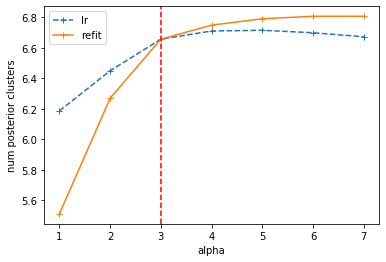

In [49]:
plt.plot(alpha_list, lr_e_num_clusters_vec, '+--')
plt.plot(alpha_list, refit_e_num_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))

plt.axvline(prior_params_dict['dp_prior_alpha'], color = 'red', linestyle = 'dashed')